# Automatic Differentiation

## Introduction: The Chain Rule

Machine learning relies heavily on computing gradients to optimize loss functions. Consider a simple loss function:

$$\ell = \left(\exp(wx+b) - y \right)^2$$

where $w$ and $b$ are parameters we want to optimize, $x$ is the input, and $y$ is the target value.

### Computation Graph

We can decompose this computation into elementary operations:

- **Multiplication**: $u = w \times x$
- **Addition**: $v = u + b$
- **Exponential**: $\hat{y} = \exp(u)$
- **Loss**: $\ell = (\hat{y} - y)^2$

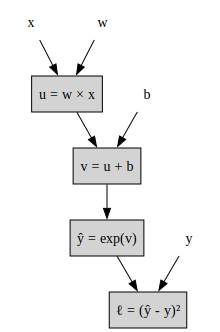

In [1]:
import graphviz

dot = graphviz.Digraph()
dot.attr(rankdir='TB')

# Input nodes - no border, no fill
dot.attr('node', shape='plaintext')
for node in [('x', 'x'), ('w', 'w'), ('b', 'b'), ('y', 'y')]:
    dot.node(*node)

# Operation nodes - light gray squares
dot.attr('node', shape='box', style='filled', fillcolor='lightgray')
for node in [('u', 'u = w × x'), ('v', 'v = u + b'), ('yhat', 'ŷ = exp(v)'), ('loss', 'ℓ = (ŷ - y)²')]:
    dot.node(*node)

# Edges
dot.edges([('w', 'u'), ('x', 'u'), ('u', 'v'), ('b', 'v'), ('v', 'yhat'), ('yhat', 'loss'), ('y', 'loss')])

dot

Each operation in this graph is a simple function we know how to differentiate.

### The Chain Rule

To compute the partial derivative, we use the **chain rule**.

$$\frac{\partial \ell}{\partial w} = \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial v} \cdot \frac{\partial v}{\partial u} \cdot \frac{\partial u}{\partial w}$$

Let's compute each derivative:

$$
\begin{align*}
\frac{\partial u}{\partial w} &= x & \text{derivative of $w \times x$}\\\\
\frac{\partial v}{\partial u} &= 1 & \text{derivative of $u + b$}\\\\
\frac{\partial \hat{y}}{\partial v} &= \exp(v) = \hat{y} & \text{derivative of $\exp(v)$}\\\\
\frac{\partial \ell}{\partial \hat{y}} &= 2(\hat{y} - y) & \qquad\text{derivative of $(\hat{y} - y)^2$}\\\\
\end{align*}
$$


<!-- 1. $
2. $\frac{\partial \hat{y}}{\partial v} = \exp(v) = \hat{y}$ (derivative of $\exp(v)$)
3. $\frac{\partial v}{\partial u} = 1$ (derivative of $u + b$)
4. $\frac{\partial u}{\partial w} = x$ (derivative of $w \times x$) -->

Therefore:
$$\frac{\partial \ell}{\partial w} = 2(\hat{y} - y) \cdot \hat{y} \cdot 1 \cdot x = 2(\exp(wx+b) - y) \cdot \exp(wx+b) \cdot x$$

Similarly, for $b$:
$$\frac{\partial \ell}{\partial b} = 2(\hat{y} - y) \cdot \hat{y} \cdot 1 = 2(\exp(wx+b) - y) \cdot \exp(wx+b)$$

### Two Modes of Automatic Differentiation

There are two possible modes to implement automatic differentiation: **Forward** and **Backward**
These modes correspond to the two possible ways to compute the chain rule from the computation graph.

- **Forward mode**: Compute derivatives from inputs to outputs
- **Backward mode**: Compute derivatives from outputs to inputs

## Forward-mode differentiation

Forward mode computes derivatives by propagating derivative information **from inputs to outputs** through the computation graph. Let's see how this works on our example.

### Example: Computing $\frac{\partial \ell}{\partial w}$

Recall our computation graph for $\ell = (\exp(wx+b) - y)^2$:
The steps are the following:

$$
\begin{align*}
&\text{1. Initialize:} & \frac{\partial w}{\partial w} &= 1\\\\
\\\\
&\text{2. Multiplication:} & \frac{\partial u}{\partial w} &= \frac{\partial u}{\partial w} \cdot 1 = x \cdot 1 = x\\\\
\\\\
&\text{3. Addition:} & \frac{\partial v}{\partial w} &= \frac{\partial v}{\partial u} \cdot \frac{\partial u}{\partial w} = 1 \cdot x = x\\\\
\\\\
&\text{4. Exponential:} & \frac{\partial \hat{y}}{\partial w} &= \frac{\partial \hat{y}}{\partial v} \cdot \frac{\partial v}{\partial w} = \hat{y} \cdot x\\\\
\\\\
&\text{5. Loss:} & \frac{\partial \ell}{\partial w} &= \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w} = 2(\hat{y}-y) \cdot \hat{y} \cdot x
\end{align*}
$$

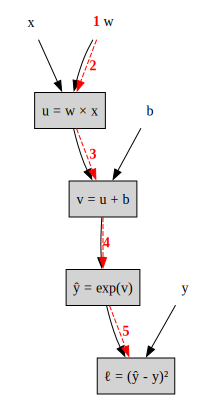

In [2]:
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import graphviz

# Create the graph structure
dot = graphviz.Digraph()
dot.attr(rankdir='TB')
dot.attr('node', shape='plaintext')
for node in [('x', 'x'), ('b', 'b'), ('y', 'y')]:
    dot.node(*node)
# w node with step 1 label
dot.node('w', '<<B><FONT COLOR="red">1</FONT></B> w>')
dot.attr('node', shape='box', style='filled', fillcolor='lightgray')
for node in [('u', 'u = w × x'), ('v', 'v = u + b'), ('yhat', 'ŷ = exp(v)'), ('loss', 'ℓ = (ŷ - y)²')]:
    dot.node(*node)

# All black plain arrows
dot.edge('w', 'u')
dot.edge('x', 'u')
dot.edge('u', 'v')
dot.edge('b', 'v')
dot.edge('v', 'yhat')
dot.edge('yhat', 'loss')
dot.edge('y', 'loss')

# Forward flow labels with step numbers in red bold font (dashed red arrows on top)
dot.edge('w', 'u', label='<<B><FONT COLOR="red">2</FONT></B>>', style='dashed', color='red')
dot.edge('u', 'v', label='<<B><FONT COLOR="red">3</FONT></B>>', style='dashed', color='red')
dot.edge('v', 'yhat', label='<<B><FONT COLOR="red">4</FONT></B>>', style='dashed', color='red')
dot.edge('yhat', 'loss', label='<<B><FONT COLOR="red">5</FONT></B>>', style='dashed', color='red')

dot

### Summary

- **One pass per input**: To compute $\frac{\partial \ell}{\partial w}$ and $\frac{\partial \ell}{\partial b}$, we need **two forward passes** (one for each parameter)
- **Efficient when**: Few inputs, many outputs (uncommon in deep learning)
- **Implementation**: Dual numbers provide an elegant way to implement forward mode

## Backward-mode differentiation

Backward mode (also called **backpropagation**) computes derivatives by propagating derivative information **from outputs to inputs** through the computation graph. This is the mode used by PyTorch, TensorFlow, and most deep learning frameworks.

**Important**: Backward mode requires **two phases**:
1. **Forward pass**: We compute all intermediate values ($u$, $v$, $\hat{y}$, $\ell$) and **store** them. We need these values (like $\hat{y}$, $x$) to compute the local derivatives during the backward pass.
2. **Backward pass**: Then, we propagate gradients from the output back to the inputs using the stored values.

### Example: Computing $\frac{\partial \ell}{\partial w}$

Using the same computation graph for $\ell = (\exp(wx+b) - y)^2$:

**Forward pass** (compute and store): $u = wx$, $v = u+b$, $\hat{y} = \exp(v)$, $\ell = (\hat{y}-y)^2$

**Backward pass** steps:

$$
\begin{align*}
&\text{1. Initialize:} & \frac{\partial \ell}{\partial \ell} &= 1\\\\
\\\\
&\text{2. Loss:} & \frac{\partial \ell}{\partial \hat{y}} &= \frac{\partial \ell}{\partial \ell} \cdot \frac{\partial \ell}{\partial \hat{y}} = 1 \cdot 2(\hat{y}-y) = 2(\hat{y}-y)\\\\
\\\\
&\text{3. Exponential:} & \frac{\partial \ell}{\partial v} &= \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial v} = 2(\hat{y}-y) \cdot \hat{y}\\\\
\\\\
&\text{4. Addition:} & \frac{\partial \ell}{\partial u} &= \frac{\partial \ell}{\partial v} \cdot \frac{\partial v}{\partial u} = 2(\hat{y}-y) \cdot \hat{y} \cdot 1\\\\
\\\\
&\text{5. Multiplication:} & \frac{\partial \ell}{\partial w} &= \frac{\partial \ell}{\partial u} \cdot \frac{\partial u}{\partial w} = 2(\hat{y}-y) \cdot \hat{y} \cdot x
\end{align*}
$$

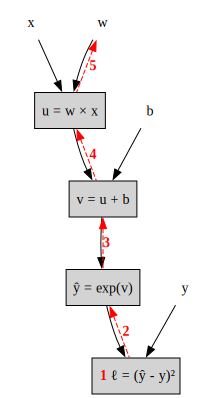

In [3]:
import graphviz

# Create the graph structure for backward mode
dot = graphviz.Digraph()
dot.attr(rankdir='TB')
dot.attr('node', shape='plaintext')
for node in [('x', 'x'), ('w', 'w'), ('b', 'b'), ('y', 'y')]:
    dot.node(*node)
dot.attr('node', shape='box', style='filled', fillcolor='lightgray')
for node in [('u', 'u = w × x'), ('v', 'v = u + b'), ('yhat', 'ŷ = exp(v)')]:
    dot.node(*node)
# loss node with step 1 label
dot.node('loss', '<<B><FONT COLOR="red">1</FONT></B> ℓ = (ŷ - y)²>')

# Edges with forward flow (no labels)
dot.edge('w', 'u')
dot.edge('x', 'u')
dot.edge('u', 'v')
dot.edge('b', 'v')
dot.edge('v', 'yhat')
dot.edge('yhat', 'loss')
dot.edge('y', 'loss')

# Add backward flow labels with step numbers in red bold font (reversed arrows)
dot.edge('yhat', 'loss', label='<<B><FONT COLOR="red">2</FONT></B>>', style='dashed', color='red', dir='back')
dot.edge('v', 'yhat', label='<<B><FONT COLOR="red">3</FONT></B>>', style='dashed', color='red', dir='back')
dot.edge('u', 'v', label='<<B><FONT COLOR="red">4</FONT></B>>', style='dashed', color='red', dir='back')
dot.edge('w', 'u', label='<<B><FONT COLOR="red">5</FONT></B>>', style='dashed', color='red', dir='back')

dot

### Summary

- **One pass for all inputs**: To compute $\frac{\partial \ell}{\partial w}$ and $\frac{\partial \ell}{\partial b}$, we need **only one backward pass** (computes gradients for all parameters at once)
- **Efficient when**: Many inputs, few outputs (common in deep learning - millions of parameters, one loss)

## Forward vs Backward: Computational Efficiency

The choice between forward and backward mode depends on the ratio of inputs to outputs in the computation graph.

### Case 1: One Input, Multiple Outputs (Forward Mode Wins)

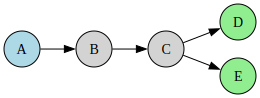

In [4]:
import graphviz

# Case 1: One input, multiple outputs
dot1 = graphviz.Digraph()
dot1.attr(rankdir='LR')

dot1.attr('node', shape='circle', style='filled', fillcolor='lightblue')
dot1.node('A', 'A')

dot1.attr('node', fillcolor='lightgray')
for node in [('B', 'B'), ('C', 'C')]:
    dot1.node(*node)
    
dot1.attr('node', fillcolor='lightgreen')
for node in [('D', 'D'), ('E', 'E')]:
    dot1.node(*node)

dot1.edges([('A', 'B'), ('B', 'C'), ('C', 'D'), ('C', 'E')])

dot1

To compute $\frac{\partial D}{\partial A}$ and $\frac{\partial E}{\partial A}$:

- **Forward mode**: One pass through A→B→C, then branch to D and E
- **Backward mode**: Two separate passes (D→C→B→A and E→C→B→A)

### Case 2: Multiple Inputs, One Output (Backward Mode Wins)

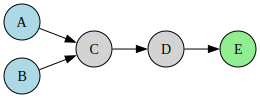

In [5]:
import graphviz

# Case 2: Multiple inputs, one output
dot2 = graphviz.Digraph()
dot2.attr(rankdir='LR')

dot2.attr('node', shape='circle', style='filled', fillcolor='lightblue')
for node in [('A', 'A'), ('B', 'B')]:
    dot2.node(*node)

dot2.attr('node', fillcolor='lightgray')
for node in [('C', 'C'), ('D', 'D')]:
    dot2.node(*node)
    
dot2.attr('node', fillcolor='lightgreen')
dot2.node('E', 'E')

dot2.edges([('A', 'C'), ('B', 'C'), ('C', 'D'), ('D', 'E')])

dot2

To compute $\frac{\partial E}{\partial A}$ and $\frac{\partial E}{\partial B}$:

- **Forward mode**: Two separate passes (A→C→D→E and B→C→D→E)
- **Backward mode**: One pass through E→D→C, then branch to A and B

### Why Deep Learning Uses Backward Mode

Neural networks typically have:
- **Millions of parameters** (inputs to the gradient computation)
- **One scalar loss** (single output)

Backward mode computes all parameter gradients in one pass. Forward mode would require one pass per parameter.

**Example**: Network with 1M parameters
- Backward: 1 forward + 1 backward = 2 passes
- Forward: 1M passes

This is why PyTorch, TensorFlow, and all deep learning frameworks use backward mode (backpropagation).